In [1]:
## Kind of working version with 3 unknown cells (outputs something, but has some errors in the output values) 

from qiskit import QuantumCircuit, QuantumRegister, AncillaRegister
from qiskit.quantum_info import Statevector
import numpy as np
import matplotlib.pyplot as plt

## Helper Functions
from helper_functions import *

In [2]:
'''
Outline:

For a 2^2 * 2^2 Sudoku, we will implement a quantum oracle that marks conflicts in the rows and columns of the Sudoku grid. 
The oracle will use qubits to represent the cells and ancillas to mark conflicts.
1. Define a function to compare two qubits for equality and mark if two cells (each 2 qubits) are equal.
2. Define a function to check a list of cells for pairwise conflicts.
3. Define a function to apply the oracle to the Sudoku grid, which marks the conflicts using the previous function.
    For each row/column/subsquare, check if any two cells are equal (-> at most 12 ancillas).
4. Apply a diffuser to amplify marked (conflict-free) states.
5. Repeat oracle and diffuser.
6. Measure the probabilities of the variable qubits to find the most probable solutions.
7. Plot the probabilities of the variable qubits.
8. Print the most probable solutions.

'''

'\nOutline:\n\nFor a 2^2 * 2^2 Sudoku, we will implement a quantum oracle that marks conflicts in the rows and columns of the Sudoku grid. \nThe oracle will use qubits to represent the cells and ancillas to mark conflicts.\n1. Define a function to compare two qubits for equality and mark if two cells (each 2 qubits) are equal.\n2. Define a function to check a list of cells for pairwise conflicts.\n3. Define a function to apply the oracle to the Sudoku grid, which marks the conflicts using the previous function.\n    For each row/column/subsquare, check if any two cells are equal (-> at most 12 ancillas).\n4. Apply a diffuser to amplify marked (conflict-free) states.\n5. Repeat oracle and diffuser.\n6. Measure the probabilities of the variable qubits to find the most probable solutions.\n7. Plot the probabilities of the variable qubits.\n8. Print the most probable solutions.\n\n'

In [3]:
## TODO: User Input
## Known cells (fixed values)
known_cells = {
    0: 2, 1: 0, 2: 1, 3: 3,
    4: 1, 5: 3, 6: 2, 7: 0,
    8: 0, 9: 1, 10: 3, 
    12: 3
}

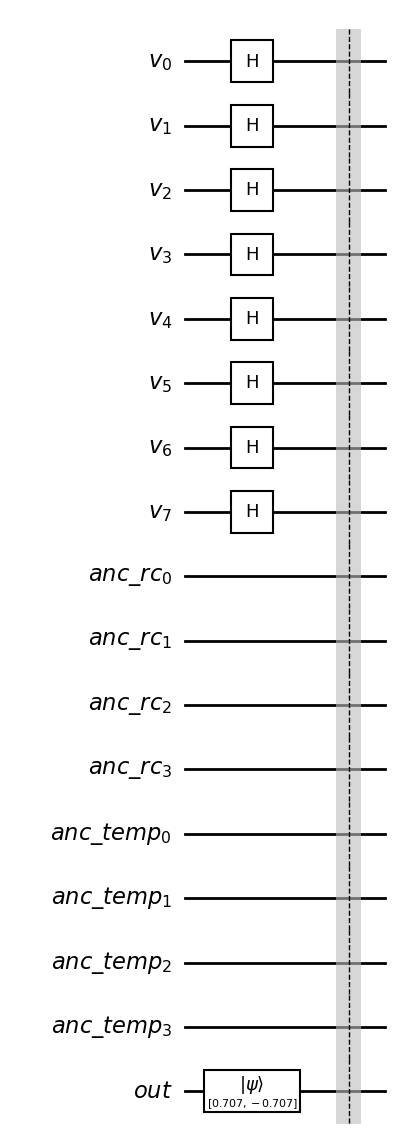

In [4]:
# Quantum Circuit Setup 

unknown_cells = [i for i in range(16) if i not in known_cells.keys()]  # Unknown cells

# Reduced RC groups for constraints (for testing with given known cells above)
rcs = [
    [8,9,10,11], [1,5,9,13], [2,6,10,14], [3,7,11,15]
]

# RCS: Row/Column/Square Constraints (takes  a long time to run with all constraints)
#rcs = [
#    [0,1,2,3], [4,5,6,7], [8,9,10,11], [12,13,14,15],
#    [0,4,8,12], [1,5,9,13], [2,6,10,14], [3,7,11,15],
#    [0,1,4,5], [2,3,6,7], [8,9,12,13], [10,11,14,15]
#]

num_vars = 2 * len(unknown_cells)  
var_qubits = QuantumRegister(num_vars, 'v')
rc_ancillas = AncillaRegister(len(rcs), 'anc_rc')  # ancillas for each RC group
temp_ancillas = AncillaRegister(4, 'anc_temp')  # temp ancillas
output = QuantumRegister(1, 'out') # output qubit for marking conflicts

qc = QuantumCircuit(var_qubits, rc_ancillas, temp_ancillas, output)

# Initialize superposition on variable qubits
qc.initialize([1, -1]/np.sqrt(2), output)
qc.h(var_qubits)
qc.barrier()

qc.draw(output="mpl", style="bw")


In [5]:
# Apply Grover iterations
N = 4**len(unknown_cells)  
num_iterations = int(np.rint(np.pi / (4 * np.arcsin(1 / np.sqrt(N))) - 1/2))

for _ in range(num_iterations):
    apply_oracle(qc, known_cells, var_qubits, output, rc_ancillas, temp_ancillas, rcs)
    qc.append(diffuser(len(var_qubits)), var_qubits[:])

qc.draw(output="mpl", style="bw")

ValueError: Image size of 2334x227204 pixels is too large. It must be less than 2^16 in each direction.

<Figure size 2334.36x227205 with 1 Axes>

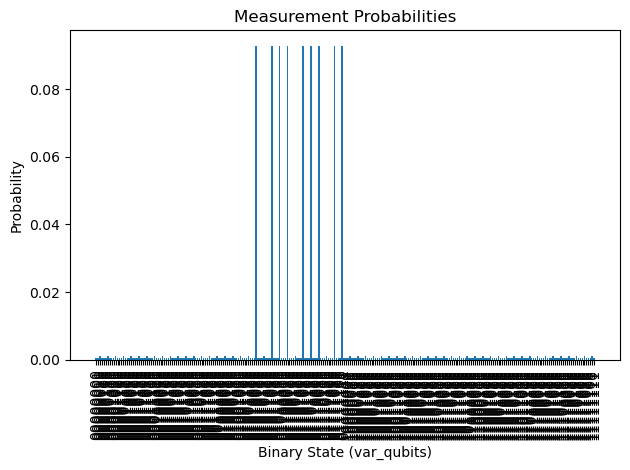

In [6]:
# Final statevector and probabilities
final_state = Statevector.from_instruction(qc)
probs = final_state.probabilities(qargs=range(num_vars))  # indices of var_qubits

# Plotting Histogram of probabilities
num_var_qubits = len(var_qubits)
labels = [format(i, f'0{num_var_qubits}b') for i in range(2**num_var_qubits)]
plt.bar(labels, probs)
plt.xlabel('Binary State (var_qubits)')
plt.ylabel('Probability')
plt.title('Measurement Probabilities')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

In [7]:
# Get labels and probabilities together
labeled_probs = list(zip(labels, probs))

# Sort by probability descending
labeled_probs.sort(key=lambda x: x[1], reverse=True)

# Print top results
print("Most probable bitstrings (variable qubits only):")
for label, prob in labeled_probs:
    if prob > 1e-3:
        print(f"{label} → {prob:.4f}")


Most probable bitstrings (variable qubits only):
01010010 → 0.0928
01101010 → 0.0928
01111110 → 0.0928
01101110 → 0.0928
01111010 → 0.0928
01100010 → 0.0928
01011110 → 0.0928
01011010 → 0.0928
01110010 → 0.0928
01000110 → 0.0012
01010110 → 0.0012
01110110 → 0.0012
00000110 → 0.0012
01000010 → 0.0012
01001110 → 0.0012
10000110 → 0.0012
11000110 → 0.0012
01001010 → 0.0012
01100110 → 0.0012
00110110 → 0.0011
00000010 → 0.0011
00100110 → 0.0011
10000010 → 0.0011
10010110 → 0.0011
00001110 → 0.0011
10110110 → 0.0011
11100110 → 0.0011
00010110 → 0.0011
10001010 → 0.0011
11110110 → 0.0011
10100110 → 0.0011
00001010 → 0.0011
11001010 → 0.0011
11001110 → 0.0011
11010110 → 0.0011
11000010 → 0.0011
10001110 → 0.0011
